# 1. Описание

Задание на стажировку:

Необходимо построить векторные предстваления (эмбеддинги) пользователей и фильмов используя нейросетевые подходы, чтобы можно было по эмбеддингу пользователя искать похожие эмбеддинги фильмов и рекомендовать ему их.

Обратить внимание на:
1. Разбиение данных на обучение и валидацию, обоснование
2. Выбор и обоснование метрики
3. Разработка архитектуры нейронной сети с пояснениями
4. Обучение и валидация
5. Решение должно быть воспроизводимым, в формате Jupyter Notebook (Google Colab / файл на Github) с подробным пояснением на каждом шаге.

В ответе прикрепить ссылку на Google Colab notebook решение (проверьте настройки приватности!) или ссылку на Github репозиторий с Jupyter Notebook решением.

Данные: https://grouplens.org/datasets/movielens/latest/

# 2. Импорт

In [1]:
# импорт библиотек
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
tqdm.pandas()

STATE = 777

In [2]:
# подключим Google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# загрузка данных
try:
    df_gen_scores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movielens/genome-scores.csv')
    df_gen_tags = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movielens/genome-tags.csv')
    df_links = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movielens/links.csv')
    df_movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movielens/movies.csv')
    df_ratings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movielens/ratings.csv')
    df_tags = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/movielens/tags.csv')
except:
    df_gen_scores = pd.read_csv('data/genome-scores.csv')
    df_gen_tags = pd.read_csv('data/genome-tags.csv')
    df_links = pd.read_csv('data/links.csv')
    df_movies = pd.read_csv('data/movies.csv')
    df_ratings = pd.read_csv('data/ratings.csv')
    df_tags = pd.read_csv('data/tags.csv')

all_df = {'df_gen_scores': df_gen_scores,
          'df_gen_tags': df_gen_tags,
          'df_links': df_links,
          'df_movies':df_movies,
          'df_ratings': df_ratings,
          'df_tags': df_tags}

In [4]:
# посмотрим на данные
for name, df in all_df.items():
    print(name.upper(), df.shape)
    display(df.sample(3))
    print('\n')

DF_GEN_SCORES (14862528, 3)


,movieId,tagId,relevance
4302857,4246,666,0.06475
9524221,45335,518,0.02350
1063606,1037,1031,0.07550




DF_GEN_TAGS (1128, 2)


,tagId,tag
991,992,suprisingly clever
283,284,dancing
969,970,stop-motion




DF_LINKS (58098, 3)


,movieId,imdbId,tmdbId
9958,32605,397103,45824.0
32372,135055,351278,189334.0
32067,134326,80439,10986.0




DF_MOVIES (58098, 3)


,movieId,title,genres
25546,117061,The Green (2011),Drama
40729,154798,A Story of the Forest: Mavka (1980),Fantasy
3868,3961,Ghoulies (1985),Horror




DF_RATINGS (27753444, 4)


,userId,movieId,rating,timestamp
24981836,255169,2924,4.0,1320437124
26374015,269285,8961,3.5,1245928319
4356477,44706,48304,3.0,1245386471




DF_TAGS (1108997, 4)


,userId,movieId,tag,timestamp
548051,103013,2821,island,1265085761
373812,73406,92637,ghost,1527400424
540696,102632,541,existentialism,1275911006


In [5]:
# объединим таблицы df_ratings и df_movies одну
df = df_ratings.merge(df_movies, on='movieId', how='left')
df.sample(5)

,userId,movieId,rating,timestamp,title,genres
9481471,97773,7361,4.5,1450041065,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
3571006,36666,62155,4.0,1288047492,Nick and Norah's Infinite Playlist (2008),Comedy|Drama|Romance
22521998,230314,349,4.0,839009453,Clear and Present Danger (1994),Action|Crime|Drama|Thriller
1761959,18019,2106,4.0,944604262,Swing Kids (1993),Drama|War
23665398,241795,87430,2.5,1518747617,Green Lantern (2011),Action|Adventure|Sci-Fi


# 3. Краткий анализ

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27753444 entries, 0 to 27753443
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
 4   title      object 
 5   genres     object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.4+ GB


,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


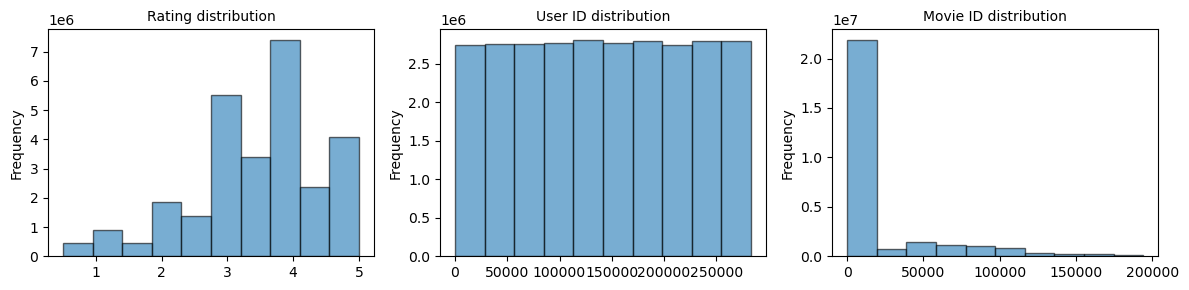

In [7]:
display(df.describe())

_, axes = plt.subplots(ncols=3, figsize=(12, 3))
df.rating.plot(kind='hist', edgecolor='black', alpha=.6, ax=axes[0]).set_title('Rating distribution', fontsize=10)
df.userId.plot(kind='hist', edgecolor='black', alpha=.6, ax=axes[1]).set_title('User ID distribution', fontsize=10)
df.movieId.plot(kind='hist', edgecolor='black', alpha=.6, ax=axes[2]).set_title('Movie ID distribution', fontsize=10)
plt.tight_layout()
plt.show()

In [8]:
print(f'''Unique USER ID: {df.userId.nunique()}
Unique MOVIE ID: {df.movieId.nunique()}
Unique RATING VALUES: {df.rating.nunique()}''')

Unique USER ID: 283228
Unique MOVIE ID: 53889
Unique RATING VALUES: 10


In [9]:
print('rating values:', *np.sort(df.rating.unique()))

rating values: 0.5 1.0 1.5 2.0 2.5 3.0 3.5 4.0 4.5 5.0


- всего 283 228 пользователей и 53889 фильма; 
- рейтинг может быть от 0.5 до 5 с шагом 0.5, всего 10 возможныз вариантов;
- средний рейтинг фильмов: 3.5;

# 4. Предобработка

In [10]:
# приведем названия колонок к привычному виду и заодно проверим данные на наличие пропусков и дубликатов;
for col_name in df.columns:
    df.rename(columns={col_name: ('_i').join(col_name.split('I'))}, inplace=True) 
print(f'пропуски - {df.isna().sum().sum()}, дубликаты - {df.duplicated().sum()}')

# избавимся от колонки `timestamp`;
# df = df.sort_values(by='timestamp').reset_index(drop='True')
df = df.drop('timestamp', axis=1)

# для уменьшения диапазона значений movie_id применим LabelEncoder();
movie_id_enc = LabelEncoder()
df['movie_id'] = movie_id_enc.fit_transform(df['movie_id'])

# сформируем целевой признак - нормализованные значения рейтингов;
min_rate, max_rate = df['rating'].min(), df['rating'].max()
df['y'] = df['rating'].apply(lambda x: (x - min_rate) / (max_rate - min_rate)).values

пропуски - 0, дубликаты - 0


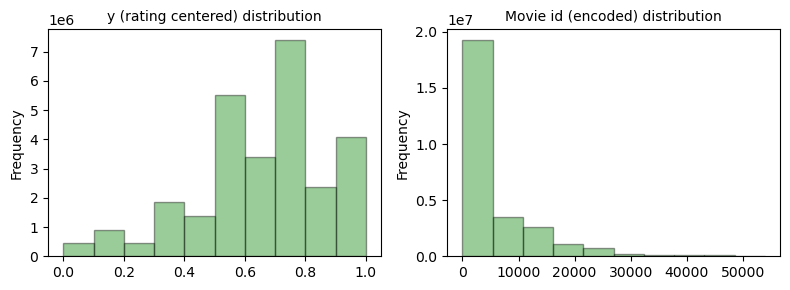

In [11]:
_, axes = plt.subplots(ncols=2, figsize=(8, 3))
df.y.plot(kind='hist', edgecolor='black', alpha=.4, ax=axes[0], color='green').set_title('y (rating centered) distribution', fontsize=10)
df.movie_id.plot(kind='hist', edgecolor='black', alpha=.4, ax=axes[1], color='green').set_title('Movie id (encoded) distribution', fontsize=10)
plt.tight_layout()
plt.show()

Наша целевая переменная 'y' - нормализованные значения рейтингов фильмову.

За счет кодирования id фильмов, удалось существенно сузить диапазон значений для упрощения вычисления эмбеддингов.

Если в дальнейшем подключать к системе признаки из других таблиц, нужно будет выполнить аналогичное преобразование, используя обученный энкодер `movie_id_enc`.

In [12]:
def allocate_realease_year(x):
    year = re.findall('[0-9][0-9][0-9][0-9]', x)
    if len(year)>0:
        return int(year[-1])
    return None

def clear_title(x):
    x = re.sub('[()0-9,]', ' ', x)
    x = (' ').join([word for word in x.split() if word.lower() not in ['the']])
    return x

# выделим из названия новый признак - год выхода фильма;
df['release_year'] = df['title'].progress_apply(allocate_realease_year)

# очистим названия фильмов от года и слова "The";
df['title'] = df['title'].progress_apply(clear_title)

100%|███████████████████████████████████████████| 27753444/27753444 [01:51<00:00, 249125.57it/s]


In [13]:
df.sample(5)

,user_id,movie_id,rating,title,genres,y,release_year
20923849,213677,3000,4.0,Babes in Toyland,Children|Comedy|Fantasy|Musical,0.777778,1934.0
15423690,157636,13677,5.0,Apollo : To Edge and Back,Documentary,1.000000,1994.0
9417119,97078,26172,2.0,Terminator Genisys,Action|Adventure|Sci-Fi|Thriller,0.333333,2015.0
15567299,158927,6836,3.0,Master and Commander: Far Side of World,Adventure|Drama|War,0.555556,2003.0
2176,32,0,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,0.888889,1995.0


### Результат анализа и предобработки данных:
- объединены две таблицы 'ratings' и 'movies';
- из названий фильмов выделен новый признак - 'release_year';
- для сужения диапазона значений, 'movie_id' был закодирован с применением LabelEncoder() из библиотеки sklearn;
- для улучшения качества предсказаний, значения рейтингов были нормализованы (переменная 'y');
- для формирования тренировочной и тестовой выборки, данные были отсортированы в хронологическом порядке (по переменной 'timestamp');
- удалена переменная 'timestamp';
- пропусков и дубликтов не обнаружено;
- типы данных соответствующие;
- аномальных значений не обнаружено;


Уникальных пользователей: 283 228;<br>
Уникальных фильмов: 53 889;<br>
Рейтинг варьируется от 0.5 до 5 (с шагом 0.5);<br>
Средний рейтинг фильмов: 3.5.

# 5. Формирование тестовой и тренировочной выборки
Для разделения данных на тестовую и валидационную выборки будем учитывать активность пользователей (количество поставленных оценок). Таким образом мы исключим проблему "холодного старта" на этапе обучения и валидации. Новичками будем считать тех, кто поставил меньше 5 оценок. Для новичков можно составить единый список, например из ТОП 15 фильмов за всю историю. Оценки остальных пользователей разделим на треинровочную и тестовую выборки, чтобы в валидационной выборке не оказалось id, которых нет в тренировочном наборе.

In [14]:
user_activity = df.groupby('user_id', as_index=False) \
.agg({'rating':'count'}) \
.rename(columns={'rating':'activity'}) \
.sort_values(by='activity', ascending=False)
print('Mean activity:', round(user_activity['activity'].mean(), 0))
display(user_activity.head())

Mean activity: 98.0


,user_id,activity
123099,123100,23715
117489,117490,9279
134595,134596,8381
212342,212343,7884
242682,242683,7515


Есть аномально высокие значения активности - пока не будем их трогать. 

In [15]:
# выделяем отдельно id новичков
newbies = user_activity[user_activity['activity'] < 5]['user_id']

# id опытных пользователей
experienced = user_activity[user_activity['activity'] >= 5]['user_id']

# оставляем в данных только опытных
df_expirienced = df.query('user_id.isin(@experienced)')

# создаем треинровочный набор данных: из опытных выбираем случайно 80% данных
train = df_expirienced.sample(frac=.8, random_state=STATE)

# берем то что осталось чтобы сформировать валидационную выборку
test = df_expirienced.drop(train.index)

# оствыляем в валидационной выборке только тех пользователей, которые есть в тренировочном наборе
test = test.query('user_id.isin(@train.user_id)')

print('Train size:', train.shape)
print('Test size:', test.shape)

Train size: (22173398, 7)
Test size: (5543324, 7)


Проверим чтобы в валидационном наборе не было пользователей, отсутствующих в тренировочной выборке.

In [16]:
train_user_id = set(train.user_id) 
test_user_id = set(test.user_id)
common_user_id = train_user_id & test_user_id 
diff = test_user_id - common_user_id
print(f'''TRAIN: {len(train_user_id)}
TEST: {len(test_user_id)}
COMMON: {len(common_user_id)}
DIFF: {len(diff)}''')

TRAIN: 266975
TEST: 258007
COMMON: 258007
DIFF: 0


Их нет.

In [17]:
# ТОП-15 фильмов

top_15 = df.groupby('title', as_index=False) \
.agg({'rating': 'sum', 'release_year':'max'}) \
.rename(columns={'rating':'sum_rating'}) \
.sort_values(by='sum_rating', ascending=False).head(15)

top_15

,title,sum_rating,release_year
44319,Toy Story,437164.5,2010.0
38965,Shawshank Redemption,433566.0,1994.0
16026,Forrest Gump,393651.0,1994.0
35242,Pulp Fiction,385700.0,1994.0
39365,Silence of Lambs,364905.0,1991.0
28272,Matrix,350836.0,1999.0
40972,Star Wars: Episode IV - A New Hope,337115.0,1977.0
38004,Schindler's List,304479.5,1993.0
23240,Jurassic Park,280195.5,1993.0
15178,Fight Club,277861.5,1999.0


# 6. Архитектура нейронной сети

Идея заключается в формировании отдельных векторных представлений для пользователей и фильмов - эмбеддингов. Эмбеддинг пользователя и эмбеддинг фильма будут объединятся в единый вектор признаков, который  будет подаваться на слой flatten для преобразования размерности. Далее будет следовать несколько скрытых слоев с произвольным количеством нейронов и функцией активации Relu - для отбрасывания отрицательных значений в признаках. Последний линейный слой будет включать всего один нейрон для предсказания значения целевой переменной (нормализованного рейтинга).


В качетсве метрики пока возьмем MAE среднюю абсолютную ошибку, т.к. ее просто интерпретировать, а в качестве функции потерь - среднюю квадратичную ошибку.

In [18]:
# задаем размер эмбеддинга
EMBEDDING_SIZE = 12

# формируем эмбеддинг пользователя
user_id_input = keras.Input(shape=(1,), name='user_id')
user_emb = keras.layers.Embedding(df.user_id.max()+1, EMBEDDING_SIZE, 
                                       input_length=1, name='user_embedding')(user_id_input)

# формируем эмбеддинг фильма
movie_id_input = keras.Input(shape=(1,), name='movie_id')                                       
movie_emb = keras.layers.Embedding(df.movie_id.max()+1, EMBEDDING_SIZE, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

# объединяем эмбеддинги в один
concat = keras.layers.Concatenate()([user_emb, movie_emb])

# слой для удаления лишней размерности входного вектора
out = keras.layers.Flatten()(concat)

# скрытые слои
out = keras.layers.Dense(26, activation='relu')(out)
out = keras.layers.Dense(12, activation='relu')(out)
out = keras.layers.Dense(8, activation='relu')(out)
out = keras.layers.Dense(4, activation='relu')(out)
# линейный слой с одним нейроном
out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

model = keras.Model(inputs = [user_id_input, movie_id_input], outputs = out)
# model.summary()

optimaizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimaizer, loss='MSE', metrics=['mae'])

# 7. Обучение модели

In [19]:
history = model.fit([train.user_id, train.movie_id], train.y,
                    batch_size=5000,
                    epochs=7,
                    verbose=1,
                    validation_data=([test.user_id, test.movie_id], test.y))

Epoch 1/7
4435/4435 [==============================] - 188s 42ms/step - loss: 0.0441 - mae: 0.1566 - val_loss: 0.0356 - val_mae: 0.1440
Epoch 2/7
4435/4435 [==============================] - 184s 42ms/step - loss: 0.0345 - mae: 0.1414 - val_loss: 0.0345 - val_mae: 0.1416
Epoch 3/7
4435/4435 [==============================] - 181s 41ms/step - loss: 0.0330 - mae: 0.1381 - val_loss: 0.0338 - val_mae: 0.1399
Epoch 4/7
4435/4435 [==============================] - 185s 42ms/step - loss: 0.0318 - mae: 0.1354 - val_loss: 0.0335 - val_mae: 0.1388
Epoch 5/7
4435/4435 [==============================] - 181s 41ms/step - loss: 0.0308 - mae: 0.1331 - val_loss: 0.0332 - val_mae: 0.1380
Epoch 6/7
4435/4435 [==============================] - 181s 41ms/step - loss: 0.0300 - mae: 0.1310 - val_loss: 0.0330 - val_mae: 0.1375
Epoch 7/7
4435/4435 [==============================] - 181s 41ms/step - loss: 0.0292 - mae: 0.1292 - val_loss: 0.0330 - val_mae: 0.1373


Построим графики значений MAE для тренировочных и тестовых данных по эпохам

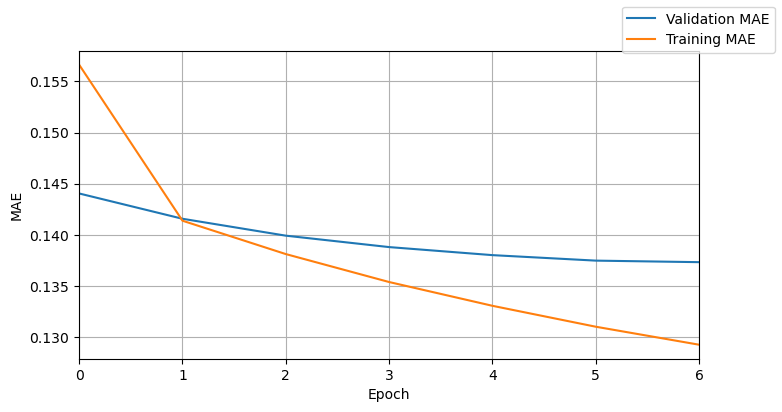

In [26]:
# сохранение модели
# model.save('/content/drive/MyDrive/Colab Notebooks/saved_model')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history.epoch, history.history['val_mae'], label='Validation MAE')
ax.plot(history.epoch, history.history['mae'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.set_xlim(left=0, right=history.epoch[-1])
ax.grid()
fig.legend()
plt.show()

Видно, что значения MAE убывают, значит модель обучается корректно.

# 8. Проверка адекватности модели
Для проверки адекватности предсказаний, сравним MAE обученной нейросети с констанотной моделью, которая для всех предсказывает средний рейтинг всех фильмов.

In [21]:
mae_rec_net = history.history['val_mae'][-1]

test['rating_median'] = test['y'].median()
mae_const_model = mean_absolute_error(test['y'], test['rating_median'])

print('mae_recomend_net:', round(mae_rec_net, 2))
print('mae_constant_model:', round(mae_const_model, 2))
print(f'Diff: {(mae_const_model - mae_rec_net) / mae_const_model:.0%}')

mae_recomend_net: 0.14
mae_constant_model: 0.19
Diff: 27%


В этом случае средняя абсолютная ошибка предсказаний нейронной сети ниже на 27%, чем у константной модели.

Также, сравним наш результат с другой константной моделью, которая всегда предсказывает среднний рейтинг соответствующего фильма.

In [27]:
mean_rate = df.groupby(['movie_id'], as_index=False) \
.agg({'y' : 'mean'}) \
.rename(columns={'y':'mean_rate'})
mean_rate = mean_rate.to_dict()

test['mean_movie_rate'] = test['movie_id'].map(mean_rate['mean_rate'])
mae_const_model_2 = mean_absolute_error(test['y'], test['mean_movie_rate'])

print('mae_recomend_net:', round(mae_rec_net, 2))
print('mae_constant_model_2:', round(mae_const_model_2, 2))
print(f'Diff: {(mae_const_model_2 - mae_rec_net) / mae_const_model_2:.0%}')

mae_recomend_net: 0.14
mae_constant_model_2: 0.17
Diff: 17%


В сравнении с константной моделью 2, нейронаая сеть предсказывает рейтинг лучше на 17% - тоже неплохо.

# 9. Вывод

__Предобработка данных:__<br>
- объединены две таблицы 'ratings' и 'movies';<br>
- из названий фильмов выделен новый признак - 'release_year';<br>
- для сужения диапазона значений, 'movie_id' был закодирован с применением LabelEncoder() из библиотеки sklearn;<br>
- для улучшения качества предсказаний, значения рейтингов были нормализованы (переменная 'y');<br>
- для формирования тренировочной и тестовой выборки, данные были отсортированы в хронологическом порядке (по переменной 'timestamp');<br>
- удалена переменная 'timestamp';
- пропусков и дубликтов не обнаружено;
- типы данных соответствующие;
- аномальных значений не обнаружено;

__Анализ:__<br>
- Уникальных пользователей: 283 228;<br>
- Уникальных фильмов: 53 889;<br>
- Рейтинг варьируется от 0.5 до 5 (с шагом 0.5);<br>
- Средний рейтинг фильмов: 3.5.<br>

- ТОП 5 фильмов:
  - Toy Story 2010
  - Shawshank Redemption 1994
  - Forrest Gump 1994
  - Pulp Fiction 1994
  - Silence of Lambs 1991
  
__Формирование тестовой и тренировочной выборки:__<br>
Для разделения данных на тестовую и валидационную выборки учитывалась активность пользователей (количество поставленных оценок). Условно разделили пользователей на "новичков" (< 5 оценок) и "опытных". Для новичков в качестве рекоммендаций составлен ТОП 15 фильмов. Оценки остальных пользователей разделим на треинровочную и тестовую выборки, чтобы в валидационной выборке не оказалось id, которых нет в тренировочном наборе.


__Архитектура нейронной сети:__<br>
Отдельные эмбеддинги для пользователей и фильмов объединяются в один вектор, подаются на несколько скрытых слоев с функцией активации Relu - для отбрасывания отрицательных значений в признаках. Последний линейный слой предсказывает значения целевой переменной (нормализованного рейтинга).
В качетсве метрики оценки качества модели была выбрана средняя абсолютная ошибка из-за простоты интерпретации.

__Обучение и проверка качества предсказаний - сравнение с константными моделями:__
Для проверки адекватности предсказаний, обученная сеть сравнивалась с двумя константными моделями:

1. конст. модель 1 предсказывает общий средний рейтинг
2. конст. модель 2 предсказывает средний рейтинг для каждого фильма

mae_recomend_net: 0.14<br>
mae_constant_model: 0.19<br>
Diff: 27%<br>

mae_recomend_net: 0.14<br>
mae_constant_model_2: 0.17<br>
Diff: 17%<br>

В первом случае качество предсказаний нейронной сети лучше на 27%, во втором - на 17%.

__Заключение:__<br>

Данная архитектура работает, но для улучшения качества предсказаний следует добавить больше признаков, например преобразовать год выпуска фильма, оценку IMDB и характерные для фильма слова из отзывов пользоваталей. 

In [ ]:
https://colab.research.google.com/drive/1G3Rx1rC5y_2R7PsUyFOS4Zuat0kFMtZ0?usp=sharing